In [15]:
from typing import Callable, Union, List
import torch
from torch import nn
from collections import OrderedDict
from torch.func import functional_call, grad, vmap

In [16]:
class LinearNN(nn.Module):
    def __init__(self,
                 num_inputs: int = 1,
                 num_layers: int = 1,
                 num_neurons: int = 5,
                 act: nn.Module = nn.Tanh()) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers
        layers = []
        layers.append(nn.Linear(self.num_inputs, num_neurons))
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])
        layers.append(nn.Linear(num_neurons, 1))  # output
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

In [17]:
def make_forward_fn(model: nn.Module, derivative_order: int = 1) -> List[Callable]:
    def f(x: torch.Tensor, params: Union[dict, tuple]) -> torch.Tensor:
        if isinstance(params, tuple):
            params_dict = tuple_to_dict_parameters(model, params)
        else:
            params_dict = params
        return functional_call(model, params_dict, (x,))

    fns = [f]
    dfunc = f
    for _ in range(derivative_order):
        dfunc = grad(dfunc)
        dfunc_vmap = vmap(dfunc, in_dims=(0, None))
        fns.append(dfunc_vmap)
    return fns

In [18]:
def tuple_to_dict_parameters(model: nn.Module, params: tuple) -> OrderedDict:
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict({k: v for k, v in zip(keys, values)})

In [19]:
if __name__ == "__main__":
    model = LinearNN(num_layers=2)
    fns = make_forward_fn(model, derivative_order=2)
    
    batch_size = 10
    x = torch.randn(batch_size)
    params = dict(model.named_parameters())
    
    fn_x = fns[0](x, params)
    assert fn_x.shape[0] == batch_size
    
    dfn_x = fns[1](x, params)
    assert dfn_x.shape[0] == batch_size
    
    ddfn_x = fns[2](x, params)
    assert ddfn_x.shape[0] == batch_size
    
    print("All assertions passed!")

All assertions passed!


In [20]:
R = 1.0
X_B= 0.0
F_B= 0.5

In [21]:
def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    def loss_fn(params: torch.Tensor, x: torch.Tensor):
        # interior loss
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)
        # boundary loss
        x0 = X_B
        f0 = F_B
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary
        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )
        return loss_value
    return loss_fn

In [22]:
torch.manual_seed(42)
parser = argparse.ArgumentParser()
parser.add_argument("-n", "--num-hidden", type=int, default=5)
parser.add_argument("-d", "--dim-hidden", type=int, default=5)
parser.add_argument("-b", "--batch-size", type=int, default=30)
parser.add_argument("-lr", "--learning-rate", type=float, default=1e-1)
parser.add_argument("-e", "--num-epochs", type=int, default=100)
args, unknown = parser.parse_known_args()
num_hidden = args.num_hidden
dim_hidden = args.dim_hidden
batch_size = args.batch_size
num_iter = args.num_epochs
tolerance = 1e-8
learning_rate = args.learning_rate
domain = (-5.0, 5.0)

In [27]:
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)
f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))
params = tuple(model.parameters())
loss_evolution = []
for i in range(num_iter):
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])
    loss = loss_fn(params, x)
    params = optimizer.step(loss, params)
    print(f"Iteration {i} with loss {float(loss)}")
    loss_evolution.append(float(loss))
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_B - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()


Iteration 0 with loss 0.5520899891853333
Iteration 1 with loss 0.08002705872058868
Iteration 2 with loss 0.10231037437915802
Iteration 3 with loss 0.12897725403308868
Iteration 4 with loss 0.07776489853858948
Iteration 5 with loss 0.06349626928567886
Iteration 6 with loss 0.0902395099401474
Iteration 7 with loss 0.09582571685314178
Iteration 8 with loss 0.07323005795478821
Iteration 9 with loss 0.062351007014513016
Iteration 10 with loss 0.0676761120557785
Iteration 11 with loss 0.07747559249401093
Iteration 12 with loss 0.07725414633750916
Iteration 13 with loss 0.06867582350969315
Iteration 14 with loss 0.0625573992729187
Iteration 15 with loss 0.06341381371021271
Iteration 16 with loss 0.06876461207866669
Iteration 17 with loss 0.07178638875484467
Iteration 18 with loss 0.06788548827171326
Iteration 19 with loss 0.06296001374721527
Iteration 20 with loss 0.06144430488348007
Iteration 21 with loss 0.06439048051834106
Iteration 22 with loss 0.06637273728847504
Iteration 23 with loss 0

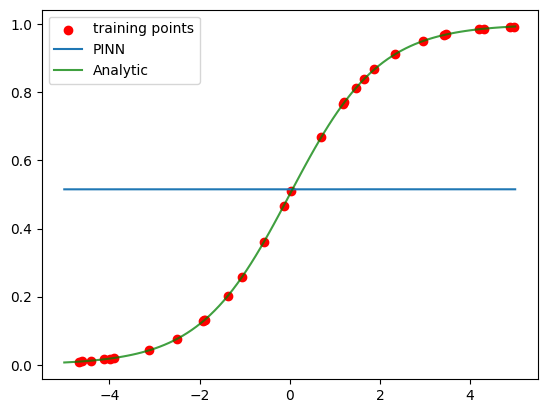

In [28]:
plt.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="r",label="training points")
plt.plot(x_eval_np, f_eval.detach().numpy(), label="PINN")
plt.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Analytic",
    color="g",
    alpha=0.75,
)
plt.legend()
plt.show()

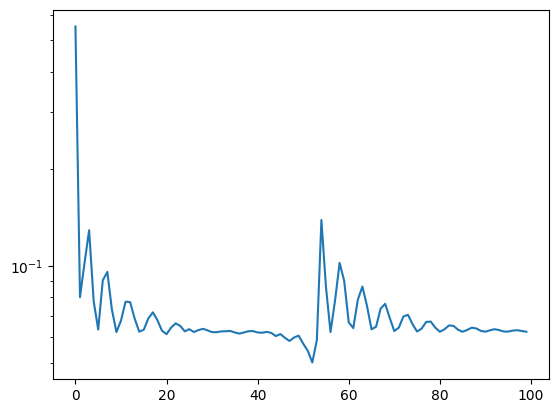

In [29]:
plt.semilogy(loss_evolution)
plt.show()

<h3>PINNS IMPLEMENTATION ON FLUID FLOW (model fluid flow around a cylinder</h3>
    
<br>
  
governing equation: fifi / fit + ½ * |fifi|^2 = H (bernoulli equation) where:
<br>1.fi (psi) is the velocity potential (a scalar field related to velocity)<br> 2.t is time <br>3.fifi represents the
gradient of fi<br>4. H is a constant representing the total head (combination of pressure and kinetic
energy)4     


In [30]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
class CylinderFlowPINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CylinderFlowPINN, self).__init__()
        self.layers = nn.Sequential(nn.Linear(input_dim, 32),
                                    nn.ReLU(),
                                    nn.Linear(32,32),
                                    nn.ReLU(),
                                    nn.Linear(32, output_dim)
                                   )
    def forward(self, x):
        psi = self.layers(x)
        return psi

In [32]:
def bernoulli_residual(psi, H):
    psi.requires_grad_(True)
    psi_grad = torch.autograd.grad(psi.sum(), psi, create_graph=True)[0]
    kinetic_energy = 0.5 * torch.linalg.norm(psi_grad, dim=1)**2
    residual = kinetic_energy + psi - H
    return torch.mean(torch.abs(residual))

In [33]:
def generate_data(num_points, radius):
    X = np.random.rand(num_points, 2)*2 -1
    y = np.zeros(num_points)
    for i in range(num_points):
        x, y_val = X[i]
        if np.linalg.norm([x,y_val])< radius:
            y[i] = 1#inside
    return torch.tensor(X, dtype = torch.float), torch.tensor(y, dtype = torch.float)

In [35]:
def train(num_epochs):
    losses = []
    progress_bar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in progress_bar:
        psi_pred = model(data_points)
        data_loss = torch.nn.functional.mse_loss(psi_pred, boundary_points.unsqueeze(1))
        physics_loss = bernoulli_residual(psi_pred, H)
        net_loss = alpha * data_loss + beta * physics_loss
        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()
        current_loss = torch.mean(net_loss.detach())
        losses.append(current_loss.item())
        progress_bar.set_description(f'Epoch {epoch}: Loss = {current_loss:.4f}')
    return losses


In [36]:
input_dim = 2
output_dim = 1
num_epochs = 2000
learning_rate = 0.001
alpha = 0.5
beta = 0.5
H = 0.5
radius = 0.5
num_data_points = 1000


In [37]:
data_points, boundary_points = generate_data(num_data_points, radius)


In [38]:
model = CylinderFlowPINN(input_dim, output_dim)

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
loss_history = train(num_epochs)


Epoch 1999: Loss = 0.0818: 100%|██████████| 2000/2000 [00:17<00:00, 113.76it/s]


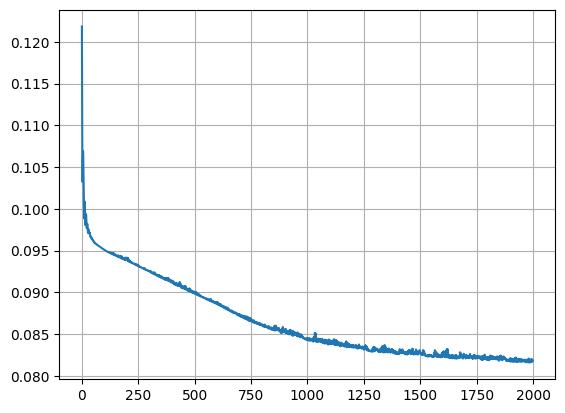

In [42]:
plt.plot(loss_history)
plt.grid()
plt.show()

In [43]:
 x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0
num_points = 100
x = np.linspace(x_min, x_max, num_points)
y = np.linspace(y_min, y_max, num_points)
X, Y = np.meshgrid(x, y)
grid_points = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),dtype=torch.float32)

In [44]:
with torch.no_grad():
    velocity_field = model(grid_points).numpy()


In [45]:
U = velocity_field[:, 0].reshape(num_points, num_points)
V = np.zeros_like(U)


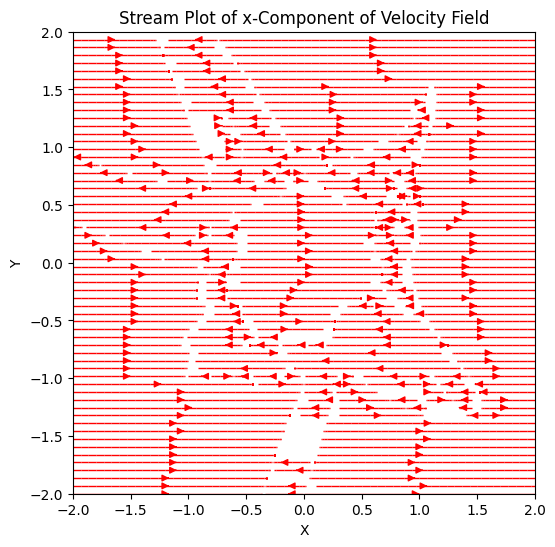

In [46]:
plt.figure(figsize=(8, 6))
plt.streamplot(X, Y, U, V, color='r', density=2.0, linewidth=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Stream Plot of x-Component of Velocity Field')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [47]:
x_grid = np.linspace(-1, 1, 200)
y_grid, x_grid = np.meshgrid(x_grid, x_grid)
grid_points = torch.tensor(np.vstack([x_grid.ravel(), y_grid.ravel()]).T,dtype=torch.float)
psi_grid = model(grid_points)

In [48]:
psi_grid = psi_grid.detach().numpy().reshape(x_grid.shape)

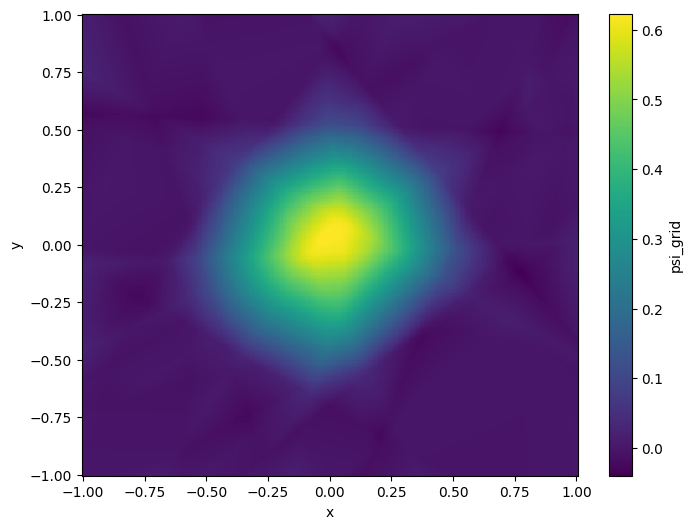

In [49]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(x_grid, y_grid, psi_grid, shading='auto')
plt.colorbar(label='psi_grid')
plt.xlabel('x')
plt.ylabel('y')
plt.show()